In [647]:
import numpy as np

In [648]:
def initialize_parameters(layer_dims):
    '''
    E.g. layer_dims = [5, 10, 25, 15, 1]; 5 features
    '''

    parameters = {}
    for l in range(1, len(layer_dims)):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

In [649]:
def sigmoid(x):
    x = np.clip(x, -500, 500) 
    sigmoid = 1/(1+np.exp(-x))
    return sigmoid

In [650]:
def softmax(Z):
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z_shift)
    return expZ / np.sum(expZ, axis=0, keepdims=True)

In [651]:
def forward_prop(A_in, W, b, activation, l):

    Z = np.dot(W, A_in) + b
    if activation=='relu':
        A_out = np.maximum(0, Z)
    elif activation=='tanh':
        A_out = np.tanh(Z)
    elif activation=='sigmoid':
        A_out = sigmoid(Z)
    elif activation=='softmax':
        A_out = softmax(Z)

    cache = {'A'+str(l-1):A_in, 'W'+str(l):W, 'b'+str(l):b, 'Z'+str(l): Z, 'activation_'+str(l):activation}

    return A_out, cache

In [652]:
def binary_cross_entropy_cost(Yhat, Y):
    epsilon = 1e-15
    m = Y.shape[1]  
    Yhat = np.clip(Yhat, epsilon, 1 - epsilon)
    cost = -1/m * np.sum((Y * np.log(Yhat)) + ((1-Y) * np.log(1-Yhat)))
    return cost

In [653]:
def categorical_crossentropy(Yhat, Y):
    # Requires one-hot encoded labels 
    epsilon = 1e-15
    Yhat = np.clip(Yhat, epsilon, 1 - epsilon)
    m = Y.shape[1] 
    cost = -1/m * np.sum(np.log(Yhat))
    return cost 

In [654]:
def back_prop(dA_out, cache, activation, l):
    
    Z, W, A_in, m = cache['Z'+str(l)], cache['W'+str(l)], cache['A'+str(l-1)], cache['A'+str(l-1)].shape[1]

    if activation=='relu':
        dZ = dA_out * (Z > 0)
    elif activation=='tanh':
        dZ = dA_out * (1-np.square(np.tanh(Z)))
    elif activation=='sigmoid':
        dZ = dA_out * sigmoid(Z) * (1-sigmoid(Z))

    dW = 1/m * np.dot(dZ, A_in.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_in = np.dot(W.T, dZ)

    return dA_in, dW, db


In [655]:
def back_prop2(dZ, caches, l):
    
    W, A_in, m = caches['W'+str(l)], caches['A'+str(l-1)], caches['A'+str(l-1)].shape[1]

    dW = 1/m * np.dot(dZ, A_in.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_in = np.dot(W.T, dZ)

    if l == 1:
        return dW, db

    Z_in = caches['Z'+str(l-1)]
    activation = caches['activation_'+str(l-1)]
    
    if activation=='relu':
        dZ_in = dA_in * (Z_in > 0)
    elif activation=='tanh':
        dZ_in = dA_in * (1-np.square(np.tanh(Z_in)))
    elif activation=='sigmoid':
        dZ_in = dA_in * sigmoid(Z_in) * (1-sigmoid(Z_in))

    return dZ_in, dW, db

In [656]:
def gradient_descent(parameters, grads, alpha=0.01):

    L = len(parameters)//2
    for l in range(1, L+1):
        parameters['W'+str(l)] -= alpha * grads['dW'+str(l)]
        parameters['b'+str(l)] -= alpha * grads['db'+str(l)]
    
    return parameters

In [ ]:
def momentum(parameters, grads, V, alpha=0.001, beta=0.9):
    
    L = len(parameters)//2
    for l in range(1, L+1):
        # Get gradients
        dWl, dbl = grads['dW'+str(l)], grads['db'+str(l)]
        # Update velocity terms
        V['dW'+str(l)] = (beta * V['dW'+str(l)]) + ((1-beta) * dWl)
        V['db'+str(l)] = (beta * V['db'+str(l)]) + ((1-beta) * dbl)
        # Update parameters
        parameters['W'+str(l)] -= alpha * V['dW'+str(l)]
        parameters['b'+str(l)] -= alpha * V['db'+str(l)]

    return parameters, V

In [658]:
def RMSprop(parameters, grads, S, alpha=0.01, beta=0.999, epsilon=1e-8):
    
    L = len(parameters)//2
    for l in range(1, L+1):

        # Get gradients
        dWl, dbl = grads['dW'+str(l)], grads['db'+str(l)]
        
        # Update squared-gradient terms
        S['dW' + str(l)] = beta * S['dW' + str(l)] + (1 - beta) * np.square(grads['dW' + str(l)])
        S['db' + str(l)] = beta * S['db' + str(l)] + (1 - beta) * np.square(grads['db' + str(l)])
        
        # Update parameters
        parameters['W'+str(l)] -= alpha * (dWl/(np.sqrt(S['dW' + str(l)])+epsilon))
        parameters['b'+str(l)] -= alpha * (dbl/(np.sqrt(S['db' + str(l)])+epsilon))

    return parameters, S


In [659]:
def Adam(parameters, grads, S, alpha=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    L = len(parameters)//2
    for l in range(1, L+1):
        
        # Initialize velocity terms
        vdW, vdb = np.zeros(grads['dW'+str(l)].shape), np.zeros(grads['db'+str(l)].shape)
        # Get gradients
        dWl, dbl = grads['dW'+str(l)], grads['db'+str(l)]
        
        # Update velocity terms
        vdW = (beta1 * vdW) + ((1-beta1) * dWl)
        vdb = (beta1 * vdb) + ((1-beta1) * dbl)
        
        # Update squared-gradient terms
        S['dW' + str(l)] = (beta2 * S['dW' + str(l)]) + ((1 - beta2) * np.square(grads['dW' + str(l)]))
        S['db' + str(l)] = (beta2 * S['db' + str(l)]) + ((1 - beta2) * np.square(grads['db' + str(l)]))
        
        # Bias correction
        vdW /= 1-beta1
        vdb /= 1-beta1
        S['dW' + str(l)] /= (1-beta2)
        S['db' + str(l)] /= (1-beta2)
        
        # Update Parameters
        parameters['W'+str(l)] -= alpha * (vdW/(np.sqrt(S['dW' + str(l)])+epsilon))          
        parameters['b'+str(l)] -= alpha * (vdb/(np.sqrt(S['db' + str(l)])+epsilon))

    return parameters, S


In [660]:
def propagate(X, Y, parameters, layer_dims, activations):
    '''
    E.g. activations = ['relu', 'relu', 'relu', 'sigmoid']
    '''

    # Forward prop
    L = len(layer_dims)
    A_in = X
    caches = []
    for l in range(1, L):
        A_out, cache = forward_prop(A_in, parameters['W'+str(l)], parameters['b'+str(l)], activations[l-1], l)
        A_in = A_out
        caches.append(cache)
    
    # Compute cost 
    cost = binary_cross_entropy_cost(A_in, Y)

    # Back prop of all layers
    grads = {}
    epsilon = 1e-15
    A_out_clipped = np.clip(A_in, epsilon, 1 - epsilon)
    dA_out = -((Y/A_out_clipped)-((1-Y)/(1-A_out_clipped)))
    for l in range(L-1, 0, -1):
        cache = caches[l-1]
        dA_in, grads['dW'+str(l)], grads['db'+str(l)] = back_prop(dA_out, cache, activations[l-1], l)
        dA_out = dA_in

    return grads, cost

In [661]:
def propagate2(X, Y, parameters, layer_dims, activations):

    # Forward prop
    L = len(layer_dims)
    A_in = X
    caches = {}
    for l in range(1, L):
        A_out, cache = forward_prop(A_in, parameters['W'+str(l)], parameters['b'+str(l)], activations[l-1], l)
        A_in = A_out
        caches = caches | cache
    
    # Compute cost 
    cost = categorical_crossentropy(A_in, Y)

    # Back prop of all layers
    grads = {}
    dZ_out = A_in - Y
    for l in range(L-1, 0, -1):
        if l == 1:
            grads['dW'+str(l)], grads['db'+str(l)] = back_prop2(dZ_out, caches, l)
        else:
            dZ_out, grads['dW'+str(l)], grads['db'+str(l)] = back_prop2(dZ_out, caches, l)

    return grads, cost

In [662]:
def make_mini_batches(X, Y, batch_size=64, seed=42):
    
    # Set seed for reproducability 
    np.random.seed(seed)
    m = X.shape[1]
    permutation = np.random.permutation(m)
    # shuffle X
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # Make mini-batches
    mini_batches= []
    for i in range(0, m, batch_size):
        X_batch = X_shuffled[:, i:i+batch_size]
        Y_batch = Y_shuffled[:, i:i+batch_size]
        mini_batches.append((X_batch, Y_batch))
        
    return mini_batches

In [ ]:
def train(X, Y, layer_dims, activations, iters=1000):
    from tqdm.notebook import tqdm
    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    # Forward and back prop
    cost_history = []
    
    # L = len(parameters)//2
    # S = {}
    # for l in range(1, L+1):
    #     # Initialize parameters
    #     S['dW' + str(l)] = np.zeros_like(parameters['W' + str(l)])
    #     S['db' + str(l)] = np.zeros_like(parameters['b' + str(l)])
    
    L = len(parameters)//2
    V = {}
    for l in range(1, L+1):
        # Initialize velocity terms
        V['dW'+str(l)], V['db'+str(l)] = np.zeros(parameters['W'+str(l)].shape), np.zeros(parameters['b'+str(l)].shape)

    # Gradient descent
    for iter in tqdm(range(iters)):
        
        mini_batches = make_mini_batches(X, Y)
        epoch_cost = 0
        
        for X_batch, Y_batch in mini_batches: 
            grads, cost = propagate2(X_batch, Y_batch, parameters, layer_dims, activations)
            # parameters, S = Adam(parameters, grads, S)
            parameters, V = momentum(parameters, grads, V) 
            epoch_cost += cost

        cost_history.append(epoch_cost/len(mini_batches))

    return parameters, cost_history

In [664]:
def predict(X, Y, parameters, activations):
    
    # Forward prop
    L = len(parameters)//2
    A_in = X
    for l in range(1, L+1):
        A_out, cache = forward_prop(A_in, parameters['W'+str(l)], parameters['b'+str(l)], activations[l-1], l)
        A_in = A_out

    # Predicted class and probability
    Y_pred = (A_out > 0.5).astype(int)
    Y_prob = A_out
    return Y_pred, Y_prob


In [665]:
# MNIST loading and processing

import pandas as pd 
train_set = pd.read_csv('mnist_train.csv')
test_set = pd.read_csv('mnist_test.csv')

# Features
X_train = train_set.drop(columns=['label'])
X_test = test_set.drop(columns=['label'])

# Labels
y_train = train_set['label']
y_test = train_set['label']

# One-hot encode labels
Y_train = pd.get_dummies(y_train)
Y_test = pd.get_dummies(y_test)

In [666]:
from sklearn.model_selection import train_test_split

# Split dataset into train and dev sets
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=0.2)

# Transpose datasets
X_train, X_dev, Y_train, Y_dev = np.array(X_train.T), np.array(X_dev.T), np.array(Y_train.T), np.array(Y_dev.T)

In [667]:
Y_train.shape

(10, 48000)

  0%|          | 0/100 [00:00<?, ?it/s]

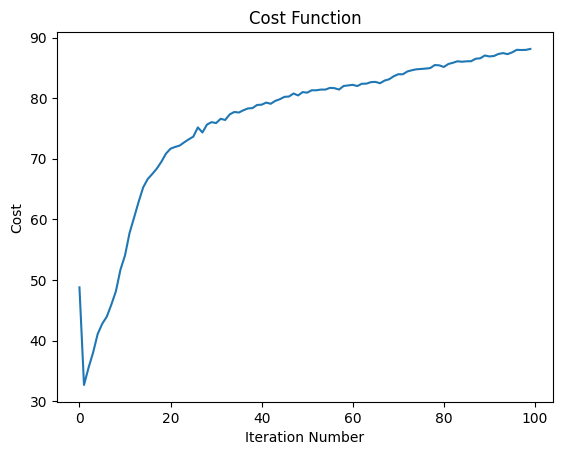

Model accuracy on dev set: 0.0


In [668]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialize model hyperparameters
activations = ['relu', 'relu', 'softmax']
layer_dims = [X_train.shape[0], 16, 16, 10]

# Train model
parameters, cost_history = train(X_train[:, :10000], Y_train[:, :10000], layer_dims, activations, iters=100)

# Predictions
Y_pred, Y_prob = predict(X_dev, Y_dev, parameters, activations)

# Cost function
plt.plot(cost_history)
plt.xlabel("Iteration Number")
plt.ylabel("Cost")
plt.title("Cost Function")
plt.show()

# Accuracy 
print(f'Model accuracy on dev set: {accuracy_score(Y_dev, Y_pred)}')

In [669]:
# # Model implementation

# from sklearn.datasets import make_blobs
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Load dataset
# X, Y = make_blobs(n_samples=1000, centers=2, n_features=2)
# # Split dataset 
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_train, X_test, Y_train, Y_test = X_train.T, X_test.T, Y_train.T.reshape(1,Y_train.shape[0]), Y_test.T.reshape(1,Y_test.shape[0])

In [670]:
# # Train model
# activations = ['relu', 'relu', 'tanh', 'sigmoid']
# layer_dims = [X.shape[1], 20, 15, 10, 1]
# parameters, cost_history = train(X_train, Y_train, layer_dims, activations)
# # Predictions
# Y_pred, Y_prob = predict(X_test, Y_test, parameters, activations)

In [671]:
# # Cost function
# import matplotlib.pyplot as plt
# plt.plot(cost_history)
# plt.xlabel("Iteration Number")
# plt.ylabel("Cost")
# plt.title("Cost Function")
# plt.show()

In [672]:
# # Accuracy
# print(f'Model accuracy: {accuracy_score(Y_test.flatten(), Y_pred.flatten())}')

In [673]:
# from PIL import Image
# def load_image(path, size=(32,32)):

#     try:
#         img = Image.open(path).convert('RGB')
#         img = img.resize(size)
#         img = np.asarray(img, dtype=np.float32)
#         img /= 255.0
#         return img
    
#     except Exception:
#         return None

# import os

# def load_dataset(root_dir='PetImages'):
#     X = []
#     Y = []
#     class_map = {"Cat": 0, "Dog": 1}

#     for class_name, label in class_map.items():
#         class_dir = os.path.join(root_dir, class_name)

#         for filename in os.listdir(class_dir):
#             path = os.path.join(class_dir, filename)
#             img = load_image(path)
            
#             if img is not None: 
#                 X.append(img)
#                 Y.append(label)
    
#     X = np.array(X)
#     Y = np.array(Y)

#     return X, Y

In [674]:
# # Model implementation

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# X, Y = load_dataset()

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# # Flatten images and transpose
# X_train = X_train.reshape(X_train.shape[0], -1).T 
# X_test  = X_test.reshape(X_test.shape[0], -1).T

# Y_train = Y_train.reshape(1, -1)  
# Y_test  = Y_test.reshape(1, -1)

# # Train model
# activations = ['relu', 'relu', 'tanh', 'sigmoid']
# layer_dims = [X_train.shape[0], 20, 15, 10, 1]
# parameters, cost_history = train(X_train, Y_train, layer_dims, activations, iters=10000)
# # Predictions
# Y_pred, Y_prob = predict(X_test, Y_test, parameters, activations)
# # Accuracy
# print(f'Model accuracy: {accuracy_score(Y_test.flatten(), Y_pred.flatten())}')

In [675]:
# # Cost function
# import matplotlib.pyplot as plt
# plt.plot(cost_history)
# plt.xlabel("Iteration Number")
# plt.ylabel("Cost")
# plt.title("Cost Function")
# plt.show()